In [1]:
!pip install torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.5 MB/s eta 0:00:00


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data_path = '/content/drive/My Drive/movielens/ml-100k/processed_data.csv'
full_data = pd.read_csv(data_path)

user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

full_data['user_id'] = user_encoder.fit_transform(full_data['user_id'])
full_data['movie_id'] = movie_encoder.fit_transform(full_data['movie_id'])

num_users = full_data['user_id'].nunique()
num_movies = full_data['movie_id'].nunique()
total_nodes = num_users + num_movies

user_nodes = full_data['user_id'].values
movie_nodes = full_data['movie_id'].values + num_users
edge_index = torch.tensor([user_nodes, movie_nodes], dtype=torch.long)
edge_attr = torch.tensor(full_data['rating'].values, dtype=torch.float)

node_features = torch.eye(total_nodes)


In [27]:

edges = edge_index.t().numpy()
ratings = edge_attr.numpy()

train_edges, test_edges, train_ratings, test_ratings = train_test_split(
    edges, ratings, test_size=0.2, random_state=42
)

train_edge_index = torch.tensor(train_edges.T, dtype=torch.long)
train_edge_attr = torch.tensor(train_ratings, dtype=torch.float)
test_edge_index = torch.tensor(test_edges.T, dtype=torch.long)
test_edge_attr = torch.tensor(test_ratings, dtype=torch.float)

train_data = Data(x=node_features, edge_index=train_edge_index, edge_attr=train_edge_attr)
test_data = Data(x=node_features, edge_index=test_edge_index, edge_attr=test_edge_attr)

In [28]:
from torch_geometric.nn import GATConv

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4)
        self.conv2 = GATConv(hidden_dim * 4, output_dim, heads=1)
        self.edge_predictor = torch.nn.Linear(output_dim * 2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        edge_src = x[edge_index[0]]
        edge_dst = x[edge_index[1]]
        edge_features = torch.cat([edge_src, edge_dst], dim=1)
        edge_predictions = self.edge_predictor(edge_features)
        return edge_predictions.squeeze()

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GNN(input_dim=total_nodes, hidden_dim=128, output_dim=32).to(device)
train_data = train_data.to(device)
test_data = test_data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

cuda


In [30]:
import torch.nn.functional as F

def train():
    model.train()
    optimizer.zero_grad()
    predicted_ratings = model(train_data)
    loss = F.mse_loss(predicted_ratings, train_data.edge_attr)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(500):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 0, Loss: 13.692867279052734
Epoch 10, Loss: 10.991617202758789
Epoch 20, Loss: 6.0386433601379395
Epoch 30, Loss: 1.2677441835403442
Epoch 40, Loss: 1.6680591106414795
Epoch 50, Loss: 1.1765300035476685
Epoch 60, Loss: 1.0964419841766357
Epoch 70, Loss: 1.0636574029922485
Epoch 80, Loss: 1.0263726711273193
Epoch 90, Loss: 1.0188847780227661
Epoch 100, Loss: 1.0115156173706055
Epoch 110, Loss: 1.003179669380188
Epoch 120, Loss: 0.9934155941009521
Epoch 130, Loss: 0.9792993068695068
Epoch 140, Loss: 0.963405430316925
Epoch 150, Loss: 0.9527774453163147
Epoch 160, Loss: 0.9424489736557007
Epoch 170, Loss: 0.9332072138786316
Epoch 180, Loss: 0.924864649772644
Epoch 190, Loss: 0.9170807600021362
Epoch 200, Loss: 0.9100950956344604
Epoch 210, Loss: 0.9043458700180054
Epoch 220, Loss: 0.8997212648391724
Epoch 230, Loss: 0.89570552110672
Epoch 240, Loss: 0.892140805721283
Epoch 250, Loss: 0.888856828212738
Epoch 260, Loss: 0.8857273459434509
Epoch 270, Loss: 0.8828020095825195
Epoch 280,

In [31]:
def evaluate():
    model.eval()
    with torch.no_grad():
        predicted_ratings = model(test_data)
        predicted_ratings = torch.clamp(predicted_ratings, min=1.0, max=5.0)
        test_loss = F.mse_loss(predicted_ratings, test_data.edge_attr).item()
        print(f'Test Loss: {test_loss}')
evaluate()


Test Loss: 1.0467348098754883


In [32]:
model.eval()
with torch.no_grad():
    predicted_ratings = model(test_data)

user_ids = test_data.edge_index[0].cpu().numpy()
movie_ids = test_data.edge_index[1].cpu().numpy() - num_users

decoded_user_ids = user_encoder.inverse_transform(user_ids)
decoded_movie_ids = movie_encoder.inverse_transform(movie_ids)

import pandas as pd
test_predictions = pd.DataFrame({
    'User ID': decoded_user_ids,
    'Movie ID': decoded_movie_ids,
    'True Rating': test_data.edge_attr.cpu().numpy(),
    'Predicted Rating': predicted_ratings.cpu().numpy()
})


   User ID  Movie ID  True Rating  Predicted Rating
0      877       381          4.0          3.781494
1      815       602          3.0          4.226086
2       94       431          4.0          4.220960
3      416       875          2.0          4.573599
4      500       182          2.0          3.867968
5      259      1074          3.0          3.115728
6      598       286          5.0          3.831844
7      886       496          4.0          3.786219
8      837        15          3.0          2.833423
9      521       184          4.0          2.778417


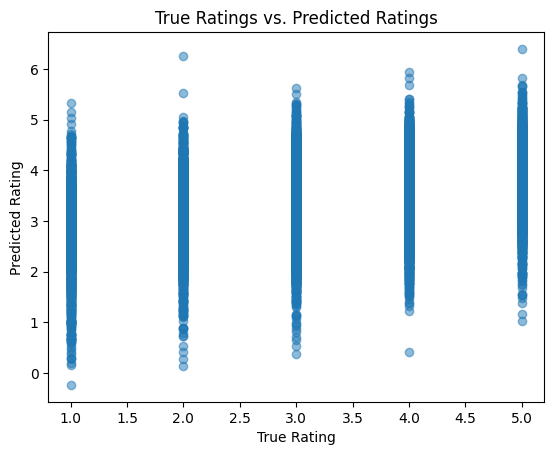

In [33]:
print(test_predictions.head(10))

import matplotlib.pyplot as plt
plt.scatter(test_predictions['True Rating'], test_predictions['Predicted Rating'], alpha=0.5)
plt.title('True Ratings vs. Predicted Ratings')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.show()

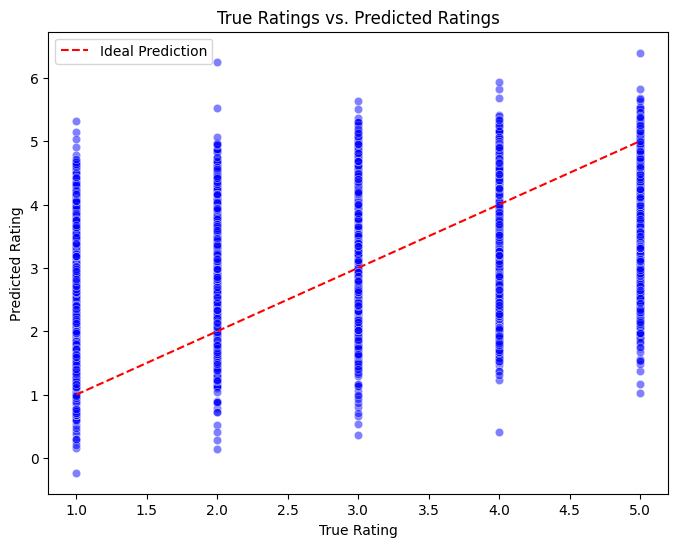

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=test_predictions['True Rating'],
    y=test_predictions['Predicted Rating'],
    alpha=0.5,
    color='blue'
)
sns.lineplot(
    x=[1, 5], y=[1, 5], color='red', linestyle='--', label='Ideal Prediction'
)
plt.title('True Ratings vs. Predicted Ratings')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.legend()
plt.show()


In [35]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_predictions['True Rating'], test_predictions['Predicted Rating'])
rmse = mse ** 0.5
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')

MSE: 1.0512
RMSE: 1.0253


In [36]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_predictions['True Rating'], test_predictions['Predicted Rating'])
print(f'MAE: {mae:.4f}')


MAE: 0.8117


In [37]:
within_half = (abs(test_predictions['True Rating'] - test_predictions['Predicted Rating']) <= 0.5).mean()
success_rate = within_half * 100
print(f'Success Rate (Accuracy within ±0.5): {success_rate:.2f}%')

Success Rate (Accuracy within ±0.5): 38.02%
